В этом блокноте рассматривается обработка данных IMDB двумя видами рекуррентных сетей

# Общая информация о рекуррентных нейронных сетях

Рекуррентная нейронная сеть перебирает последовательность поэлементно и сохраняет свое состояние, полученное при обработке прошлого элемента

Однако иногда состояние сбрасывается. Например с IMDB оно будет сохраняться в течении одного отзыва, но между отзывами - сбрасываться.



Реализация простой псевдорекуррентной нейронной сети с помощью numpy

In [ ]:
import numpy as np

# временные интервалы во входной последовательности
timesteps = 100
# размерность входных признаков
input_features = 32
# размерность выходных признаков
output_features = 64

inputs = np.random.random((timesteps, input_features))

# изначально состояние инициализируется нулевым тензором
state_tensor = np.zeros((output_features,))

# создание матриц со случайными весами
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

succesive_outputs = []
for input_tensor in inputs:
  # dot() - скалярное призведение тензоров
  output_tensor = np.tanh(np.dot(W, input_tensor) + np.dot(U, state_tensor) + b)
  succesive_outputs.append(output_tensor)
  # переприсваивание состояния на только что полученный тензор
  state_tensor = output_tensor

# двумерный тензор с формой (временные_интервалы, входные признаки)
final_output = np.concatenate(succesive_outputs, axis=0)

final_output

array([0.99999996, 0.99999964, 0.99999799, ..., 1.        , 1.        ,
       1.        ])

# SimpleRNN

Показанная выше реализация соответствует слою SimpleRNN. 

Пример, где используется слой SimpleRNN и возвращается результат только для последней временной последовательности

In [ ]:
# слой SimpleRNN принимает тензор формы (кол-во пакетов, временные метки, входные признаки)
# слой может возвращать либо векторные представления сразу для всех временных интервалов, то есть тензор формы (размер_пакета, временные интервалы, выходные признаки)
# или же может возвращать векторное представление для последнего интервала времени, то есть тензор формы (размер_пакета, выходные признаки)
# выбор осуществялется аргументов return_sequences конструктора

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

# такая сеть возвращает представления только последнего временного интервала
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

# такая сеть возвращает представления всех временных интервалов
model = Sequential()
model.add(Embedding(1000, 32))
# при наложении реккурентных слоев друг на друга, нужно, чтобы каждый из них
# возвращал представления для всех временных промежутков
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()
# заметна разница в форме выходного тензора



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
____________________________

Теперь создадим рекуррентную сеть для обработки отзывов с IMDB

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# количество слов, рассматриваемых, как признаки
max_features = 10000
# обрезка каждого отзыва после такого количества слов
maxlen = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f'{len(x_train)} train sequences')
print(f'{len(x_test)} test sequences')

print(f'In the beginning x_train is \n {x_train} \n and x_test is \n{x_test}')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train)
x_test = sequence.pad_sequences(x_test)

print(f'After padding x_train is \n {x_train} \n and x_test is \n {x_test}')



Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
In the beginning x_train is 
 [list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 10

Обучение модели со слоями Embedding и SimpleRNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2).history

Графики тренировки модели с SimpleRNN

In [8]:
def draw_graph(history):
  import matplotlib.pyplot as plt
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [ ]:
draw_graph(history)

Оценка точности работы сети с SimpleRNN

In [ ]:
mse, mae = model.evaluate(x_test, y_test, verbose=0, batch_size=128)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

# LSTM

Главное отличие LSTM от SimpleRNN в том, что в LSTM есть некий "вектор" или "нить", которая хранит прошлые состояния сети и пронизывает все будущие состояния. Это похоже на конвейер, который движется параллельно работе сети, и на него в любоей момент времени можно положить данные, а также снять их.

Лучшее объяснение работы - здесь:

https://www.youtube.com/watch?v=Kv4NyVW9IZ4


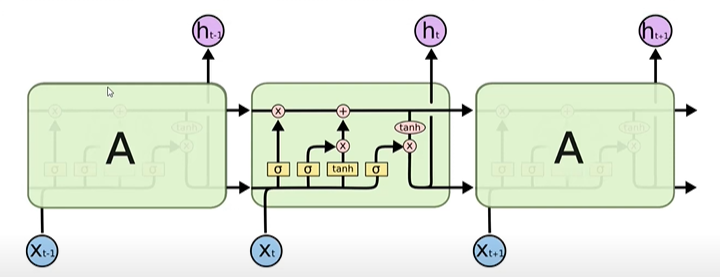

Создадим сеть с LSTM для отзывов IMDB

In [4]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

# количество слов, рассматриваемых, как признаки
max_features = 10000
# обрезка каждого отзыва после такого количества слов
maxlen = 500

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2).history

Epoch 1/10
157/157 [==============================] - 283s 2s/step - loss: 0.4970 - accuracy: 0.7588 - val_loss: 0.3245 - val_accuracy: 0.8680
Epoch 2/10
157/157 [==============================] - 283s 2s/step - loss: 0.2907 - accuracy: 0.8860 - val_loss: 0.3181 - val_accuracy: 0.8826
Epoch 3/10
157/157 [==============================] - 283s 2s/step - loss: 0.2277 - accuracy: 0.9148 - val_loss: 0.3072 - val_accuracy: 0.8696
Epoch 4/10
157/157 [==============================] - 281s 2s/step - loss: 0.1992 - accuracy: 0.9270 - val_loss: 0.2967 - val_accuracy: 0.8820
Epoch 5/10
157/157 [==============================] - 281s 2s/step - loss: 0.1794 - accuracy: 0.9376 - val_loss: 0.2967 - val_accuracy: 0.8924
Epoch 6/10
157/157 [==============================] - 283s 2s/step - loss: 0.1595 - accuracy: 0.9438 - val_loss: 0.4673 - val_accuracy: 0.8306
Epoch 7/10
157/157 [==============================] - 282s 2s/step - loss: 0.1429 - accuracy: 0.9485 - val_loss: 0.3259 - val_accuracy: 0.8802

Графики тренировки сети с LSTM


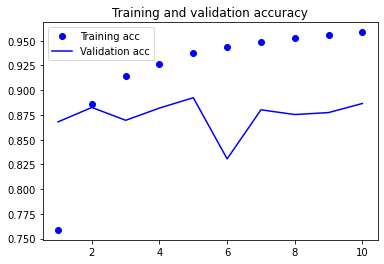

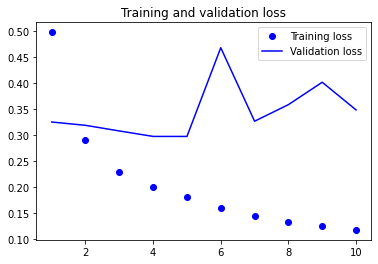

In [9]:
draw_graph(history)

Оценка точности работы сети с LSTM

In [12]:
mse, mae = model.evaluate(x_test, y_test, verbose=1, batch_size=128)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

# выдает mse =  mae = 

196/196 [==============================] - 66s 339ms/step - loss: 0.4059 - accuracy: 0.8664
[INFO] Mean squared error is 0.4059000015258789
[INFO] Mean absolute error is 0.8664399981498718


Полученные результаты значительно лучше, чем при использовании SimpleRNN и немного лучше, чем при использовании полносвязной сетки ранее. Но этот показатель все-же далек от 100%, потому что на самом деле LSTM не очень хорошо подходит для определения эмоциональной окраски текста. А вот для диалога или машинного перевода - отлично подходит.